In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/navires-2024-fait-main/ships24.tgz


# Auteurs

Réalisé par :

- [Leo DEVIN](https://www.kaggle.com/lodevin)
- [Phu-Hung DANG](https://www.kaggle.com/phuhungdang)

# Imports

## Bibliothèques et fonctions utilisées

Ce projet utilise plusieurs bibliothèques et fonctions importantes :

1. **tarfile** : Cette bibliothèque est utilisée pour la manipulation de fichiers d'archives, tels que les fichiers `.tar` et `.gz`.

2. **TensorFlow** : Il s'agit d'une bibliothèque open-source d'apprentissage automatique et d'intelligence artificielle. Dans ce projet, nous utilisons TensorFlow pour créer et entraîner un modèle de réseau de neurones convolutifs (CNN).

    - `ImageDataGenerator` : Cette fonction est utilisée pour générer des données d'images en temps réel, avec des transformations de données optionnelles telles que la rotation, le zoom et le décalage.

    - `layers` et `models` : Ces modules sont utilisés pour créer et manipuler les couches et les modèles dans TensorFlow.

        * `Conv2D` : Cette fonction crée une couche de convolution 2D, qui est un filtre glissant appliqué sur les données d'entrée.
        * `MaxPooling2D` : Cette fonction crée une couche de sous-échantillonnage 2D, qui réduit la dimension spatiales en prenant la valeur maximale dans la fenêtre de sous-échantillonnage.
        * `Flatten` : Cette fonction crée une couche qui aplatit les données d'entrée.
        * `Dense` : Cette fonction crée une couche entièrement connectée.
        * `Dropout` : Cette fonction crée une couche qui ignore aléatoirement un pourcentage défini des neurones lors de l'entraînement, ce qui aide à prévenir le surapprentissage.

    - `callbacks` : Ce module est utilisé pour créer et manipuler les callbacks dans TensorFlow.

        * `EarlyStopping` : Cette fonction arrête l'entraînement lorsqu'une métrique de surveillance n'a pas été améliorée pendant un certain nombre d'époques.
        * `ModelCheckpoint` : Cette fonction enregistre le modèle après chaque époque ou à des intervalles spécifiés.
        * `ReduceLROnPlateau` : Cette fonction réduit le taux d'apprentissage lorsqu'une métrique de surveillance n'a pas été améliorée pendant un certain nombre d'époques.

    - `plot_model` : Cette fonction est utilisée pour créer un diagramme visuel du modèle TensorFlow.

    - `Adam` : Il s'agit d'un algorithme d'optimisation de premier ordre utilisé pour ajuster les poids des neurones dans un réseau de neurones.

3. **PIL (Pillow)** : La bibliothèque PIL (Python Imaging Library) est utilisée pour ouvrir, manipuler et enregistrer différents formats de fichiers image.

4. **os** : Cette bibliothèque est utilisée pour la manipulation du système d'exploitation, comme l'interaction avec le système de fichiers.

5. **Matplotlib** : Il s'agit d'une bibliothèque de visualisation de données 2D pour Python. Dans ce projet, nous utilisons Matplotlib pour afficher des images et des graphiques.

6. **NumPy** : Cette bibliothèque est utilisée pour le traitement des données numériques en Python. Elle fournit des structures de données et des fonctions pour manipuler efficacement les tableaux et les matrices.


In [2]:
import tarfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

2024-05-28 23:29:16.016071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 23:29:16.016168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 23:29:16.152149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Extraction des images de navires

Le jeu de données est fourni sous forme d'archive compressée `.tar.gz`. Nous devons extraire les images de navires avant de les utiliser:

In [3]:
print("Extracting ships...")

# Open the tar.gz file
with tarfile.open('/kaggle/input/navires-2024-fait-main/ships24.tgz', 'r:gz') as tar:
    # Extract all files to the current directory
    tar.extractall()
    
print("Extraction done.")

Extracting ships...
Extraction done.


In [4]:
!ls /kaggle/working

ships_gray  test.npy


## Création d'un générateur d'images (ImageDataGenerator)

Le générateur d'images (`ImageDataGenerator`) est un outil puissant fourni par TensorFlow pour la génération de données d'images en temps réel, avec des transformations de données optionnelles telles que la rotation, le zoom et le décalage. Dans ce projet, nous utiliserons `ImageDataGenerator` pour normaliser les données d'images et effectuer une augmentation de données.

Lors de la création d'un objet `ImageDataGenerator`, nous pouvons spécifier plusieurs paramètres pour définir les transformations de données souhaitées. Par exemple, nous pouvons définir la plage de cisaillement aléatoire, la plage de zoom aléatoire, l'inversion horizontale et la plage de rotation aléatoire. De plus, nous pouvons utiliser le paramètre `validation_split` pour définir la proportion d'images à utiliser pour la validation.

## Création des générateurs d'entraînement et de validation

Après avoir créé un objet `ImageDataGenerator` avec les transformations de données souhaitées, nous pouvons utiliser la méthode `flow_from_directory()` pour créer des générateurs d'entraînement et de validation.

La méthode `flow_from_directory()` prend plusieurs paramètres, tels que le chemin d'accès aux images, la taille cible des images, la taille du lot et le mode de classe. Dans ce projet, nous utiliserons le mode de classe `'categorical'` pour la classification multiclasse.

Nous pouvons également utiliser le paramètre `subset` pour spécifier si le générateur doit fournir des données d'entraînement ou de validation. En définissant `subset='training'`, nous créons un générateur d'entraînement, et en définissant `subset='validation'`, nous créons un générateur de validation.

Il est important de définir une valeur de graine (`seed`) pour s'assurer que les données d'entraînement et de validation sont divisées de manière cohérente à chaque exécution du code.


In [13]:
# Create an ImageDataGenerator for (optional) augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255.0,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2,
                             height_shift_range=0.1,
                             rotation_range=0.2,
                             brightness_range=(0.8, 1.2),
                             shear_range=0.2,
                             fill_mode='nearest'
                            )

print("Datagen created.")

SEED = 69
path = '/kaggle/working/ships_gray'
image_size = (128, 192)

train_generator = datagen.flow_from_directory(
    path,
    target_size=image_size,
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    color_mode='grayscale'
)

val_generator = datagen.flow_from_directory(
    path,
    target_size=image_size,
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    color_mode='grayscale'
)

Datagen created.
Found 33768 images belonging to 10 classes.
Found 8436 images belonging to 10 classes.


## Affichage d'images

Lorsque nous travaillons avec des données d'images, il est souvent utile de visualiser les images elles-mêmes pour mieux comprendre le jeu de données et vérifier si les images sont prétraitées correctement.

Nous pouvons utiliser la bibliothèque Matplotlib pour afficher des images dans un notebook Jupyter. En général, les étapes pour afficher une image sont les suivantes :

1. Charger l'image à partir du système de fichiers ou du générateur de données.
2. Convertir l'image en un format compatible avec Matplotlib, tel qu'un tableau NumPy.
3. Créer une figure et un sous-tracé à l'aide de la fonction `plt.subplot()`.
4. Afficher l'image à l'aide de la fonction `plt.imshow()`.
5. Ajouter des titres, des étiquettes d'axe et d'autres annotations si nécessaire.
6. Afficher la figure à l'aide de la fonction `plt.show()`.

Nous pouvons également afficher plusieurs images en créant une grille de sous-tracés à l'aide de la fonction `plt.subplots()`.


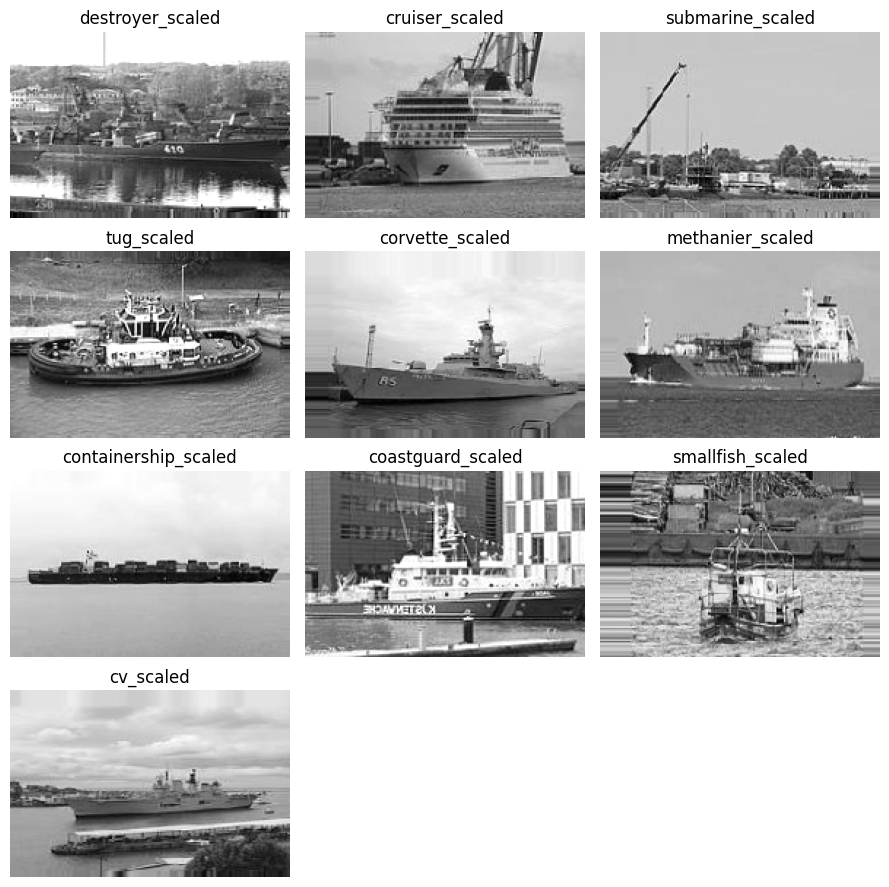

In [14]:
class_names = sorted(os.listdir(path))

# Initialize a dictionary to keep track of the seen classes
seen_classes = {}

# Plot one image from each class
plt.figure(figsize=(9, 9))  # Increase figure size to accommodate 10 subplots

# Get the first batch of images and labels
images, labels = next(train_generator)

for i in range(len(images)):
    label_index = np.argmax(labels[i])
    class_name = class_names[label_index]

    # Check if we have already seen this class
    if class_name not in seen_classes:
        seen_classes[class_name] = True

        ax = plt.subplot(4, 3, len(seen_classes))  # Adjust layout to 4x3 grid
        img = images[i] * 255
        img = img.astype("uint8")
        plt.imshow(img, cmap='gray')  # Specify colormap as 'gray'
        plt.title(f"{class_name}")
        plt.axis("off")

    # If we have seen images from all classes, break out of the loop
    if len(seen_classes) == len(class_names):
        break

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Définition, compilation et entraînement du modèle

Pour créer un modèle de reconnaissance de navires, nous pouvons utiliser un réseau de neurones convolutif (CNN) avec plusieurs blocs de convolution et des couches entièrement connectées.

Tout d'abord, nous définissons la forme d'entrée du modèle en fonction de la taille des images prétraitées. Ensuite, nous ajoutons des couches de prétraitement, telles que la mise à l'échelle et la normalisation par lots.

Nous ajoutons ensuite plusieurs blocs de convolution, chacun composé d'une couche de convolution 2D, d'une normalisation par lots et d'une activation ReLU. Nous utilisons également un sous-échantillonnage maximal après chaque bloc de convolution pour réduire la dimensionnalité. De plus, nous ajoutons une couche de abandon pour régulariser le modèle et prévenir le surapprentissage.

Après les blocs de convolution, nous ajoutons des couches entièrement connectées pour effectuer la classification. Nous utilisons une couche plate pour aplatir le tenseur de sortie des couches de convolution, suivie d'une couche dense avec une activation ReLU. Nous ajoutons également une normalisation par lots et une couche de abandon. Enfin, nous ajoutons une couche dense de sortie avec une activation softmax, en supposant que nous avons 10 classes de navires à reconnaître.

Une fois le modèle défini, nous devons le compiler avec un optimiseur, une fonction de perte et des métriques. Nous pouvons utiliser l'optimiseur Adam avec un taux d'apprentissage approprié. Pour la reconnaissance de navires multiclasse, nous utilisons la perte d'entropie croisée catégorique et la précision comme métrique.

Après avoir compilé le modèle, nous pouvons afficher un résumé du modèle pour vérifier sa structure et le nombre de paramètres.

Enfin, nous entraînons le modèle en utilisant les générateurs d'entraînement et de validation que nous avons créés précédemment. Nous pouvons également définir des callbacks, tels que la réduction du taux d'apprentissage en cas de stagnation et l'arrêt précoce, pour améliorer les performances du modèle et réduire le temps d'entraînement.


In [19]:
input_shape = (128, 192, 1)

model = models.Sequential([

    # First Convolutional Block
    layers.Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(1e-4)),
    layers.Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # Fourth Convolutional Block
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    
    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Assuming 10 classes for ship recognition
])

# Define the optimizer
optimizer = Adam(learning_rate=0.001, weight_decay=1e-4)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Define the callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 128, 192, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 192, 64)   │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 192, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 96, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 49152)          │             

 Total params: 112,603,082 (429.55 MB)

 Trainable params: 112,592,970 (429.51 MB)

 Non-trainable params: 10,112 (39.50 KB)

In [20]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  30


## Entraînement du modèle

Après avoir défini, compilé et configuré les callbacks pour notre modèle de reconnaissance de navires, nous pouvons maintenant procéder à l'entraînement du modèle.

Nous utilisons la méthode `fit()` du modèle pour lancer le processus d'entraînement. Nous fournissons le générateur d'entraînement comme données d'entraînement et le générateur de validation comme données de validation.

Nous définissons également le nombre d'époques, qui représente le nombre de fois que le modèle traite l'ensemble du jeu de données d'entraînement. Enfin, nous fournissons les callbacks que nous avons définis précédemment pour surveiller et améliorer l'entraînement.

Pendant l'entraînement, le modèle affiche la perte et la précision pour chaque époque sur les jeux de données d'entraînement et de validation. Nous pouvons utiliser ces métriques pour évaluer les performances du modèle et détecter tout signe de surapprentissage ou de sous-apprentissage.

Une fois l'entraînement terminé, nous pouvons enregistrer le modèle entraîné pour une utilisation ultérieure et procéder à l'évaluation et à la prédiction sur de nouvelles images de navires.


In [ ]:
train_log = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100


W0000 00:00:1716940016.902027     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/528 ━━━━━━━━━━━━━━━━━━━━ 2:33 371ms/step - accuracy: 0.1398 - loss: 4.7664

W0000 00:00:1716940058.487279     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.2233 - loss: 4.0864

W0000 00:00:1716940149.997904     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716940170.806007     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


528/528 ━━━━━━━━━━━━━━━━━━━━ 180s 294ms/step - accuracy: 0.2234 - loss: 4.0854 - val_accuracy: 0.0785 - val_loss: 6.0610 - learning_rate: 0.0010
Epoch 2/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0.4660 - loss: 2.7800 - val_accuracy: 0.3695 - val_loss: 3.5076 - learning_rate: 0.0010
Epoch 3/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0.5687 - loss: 2.5492 - val_accuracy: 0.5755 - val_loss: 2.5803 - learning_rate: 0.0010
Epoch 4/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0.6274 - loss: 2.4336 - val_accuracy: 0.5172 - val_loss: 2.8042 - learning_rate: 0.0010
Epoch 5/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 134s 252ms/step - accuracy: 0.6700 - loss: 2.3841 - val_accuracy: 0.5403 - val_loss: 2.8008 - learning_rate: 0.0010
Epoch 6/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0.6979 - loss: 2.2739 - val_accuracy: 0.6432 - val_loss: 2.3890 - learning_rate: 0.0010
Epoch 7/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0

## Graphiques d'accuracy et de perte

Les graphiques suivants montrent l'évolution de l'accuarcacy et de la perte d'entraînement et de validation au fil des époques. Le graphique de gauche affiche l'accuracy, tandis que le graphique de droite affiche la perte. Les légendes sont fournies pour distinguer les courbes.

Training accuracy: 0.980603
Validation accuracy: 0.941560


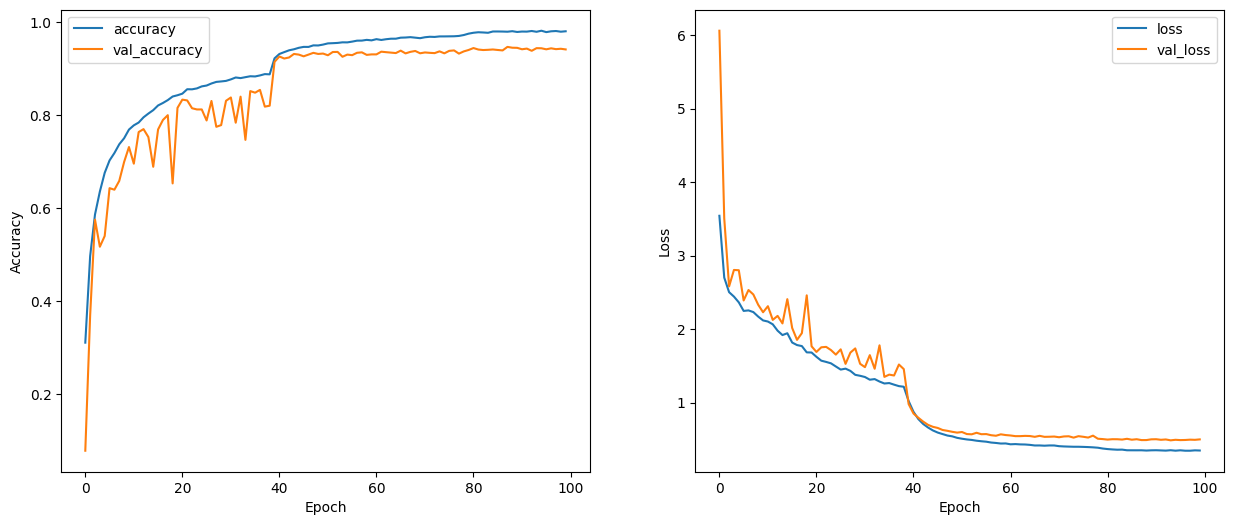

In [22]:
# Set the size of the figure
plt.figure(figsize=(15, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_log.history['accuracy'], label='accuracy')
plt.plot(train_log.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Print accuracy
print('Training accuracy: %f' % train_log.history['accuracy'][-1])
print('Validation accuracy: %f' % train_log.history['val_accuracy'][-1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_log.history['loss'], label='loss')
plt.plot(train_log.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()

Les valeurs d'accuarcacy et de perte d'entraînement et de validation finales sont également affichées.

In [23]:
# Print loss
print('Training loss: %f' % train_log.history['loss'][-1])
print('Validation loss: %f' % train_log.history['val_loss'][-1])

plt.show()

Training loss: 0.346436
Validation loss: 0.497817


  7/264 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step 

W0000 00:00:1716972547.763773     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step


W0000 00:00:1716972556.320929     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


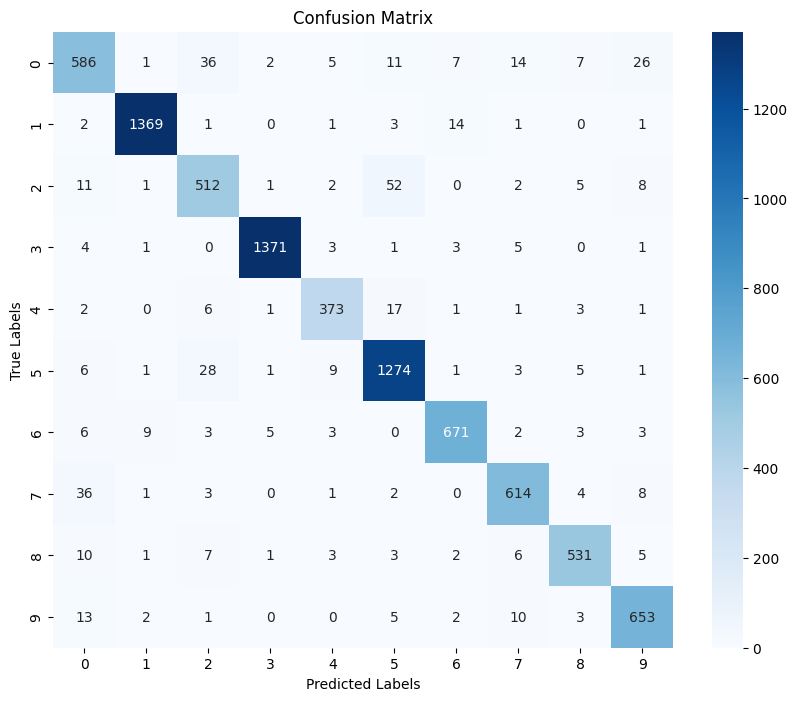

Class Weights: [1.21381295 0.60603448 1.42020202 0.60734341 2.08296296 0.63476298
 1.19659574 1.26098655 1.48260105 1.22438316]
Accuracy: 0.9428639165481271
Precision: [0.86686391 0.98773449 0.85762144 0.99204052 0.9325     0.93128655
 0.95720399 0.9331307  0.94652406 0.92362093]
Recall: [0.84316547 0.98347701 0.86195286 0.98704104 0.92098765 0.9586155
 0.95177305 0.91778774 0.93321617 0.94775036]
F1-score: [0.85485047 0.98560115 0.8597817  0.98953446 0.92670807 0.94475343
 0.9544808  0.92539563 0.93982301 0.93553009]
Macro-average Precision: 0.9328526595362687
Macro-average Recall: 0.9305766856594279
Macro-average F1-score: 0.9316458811065754


In [24]:
# Récupération des étiquettes de validation
val_labels = []
val_data = []
for batch in val_generator:
    val_data.append(batch[0])
    val_labels.extend(np.argmax(batch[1], axis=1))
    if len(val_labels) >= val_generator.samples:
        break

val_data = np.concatenate(val_data)
val_labels = np.array(val_labels)

# Prédictions des étiquettes
predictions = model.predict(val_data)
pred_labels = np.argmax(predictions, axis=1)

# La matrice de confusion
cm = confusion_matrix(val_labels, pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Récupération des étiquettes de classe uniques
class_labels = np.unique(val_labels)

# Calcul des poids de classe
class_weights_ = compute_class_weight(class_weight='balanced', classes=class_labels, y=val_labels)
print("Class Weights:", class_weights_)

# Calcul des métriques
accuracy = accuracy_score(val_labels, pred_labels)
precision = precision_score(val_labels, pred_labels, average=None)
recall = recall_score(val_labels, pred_labels, average=None)
f1 = f1_score(val_labels, pred_labels, average=None)

# Calcul des moyennes macro
macro_precision = precision_score(val_labels, pred_labels, average='macro')
macro_recall = recall_score(val_labels, pred_labels, average='macro')
macro_f1 = f1_score(val_labels, pred_labels, average='macro')

# Affichage des scores
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Macro-average Precision:", macro_precision)
print("Macro-average Recall:", macro_recall)
print("Macro-average F1-score:", macro_f1)


In [25]:
X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

print(X_test.shape)

X_test = np.expand_dims(X_test, axis=-1)

print(X_test.shape)

res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")

(1017, 128, 192)
(1017, 128, 192, 1)
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step


W0000 00:00:1716972575.986904     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
!head reco_nav.csv

ID,Category
0,5
1,2
2,2
3,3
4,9
5,8
6,4
7,5
8,7


In [27]:
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv